<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Snythetic Modulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import 

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pickle

from scipy.signal import resample, hilbert, correlate, decimate
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace



### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from RingLaser import RingLaser


In [4]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


### Own Plotting Methods

In [5]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

In [6]:

def __upsample_FIR(signal_in, sampling_factor, sps):
    
    from scipy.signal import upfirdn, resample_poly
    
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower)
    
    time_out = np.arange(len(signal_out))/(sps*sampling_factor)
    
    return signal_out, time_out


In [7]:

def __interpolation(trace, time, T, sps):
    
    from scipy.signal import resample
    from numpy import arange
    
    ## interpolate modeltrace to sps 
    l1 = trace.size
    
    trace = resample(trace, int(T*sps+1))
#     time = resample(time, int(T*sps+1))    
    
    l2 = trace.size
    
    print(f"modeltrace is interpolated: {l1} samples --> {l2} samples")
#     print(f"time_modeltrace is interpolated: {l1} samples --> {l2} samples")

    time = arange(0, T+1/sps, 1/sps)

    return trace, time


## Configurations

In [8]:


T = 1600

sps = 5000

sgnc = ROMY_Z.get_sagnac_frequency()


modulation_index = ROMY_Z.get_scale_factor()

modulation_scheme = 3



oversampling = True
oversampling_factor = 2

In [9]:
from obspy import UTCDateTime
from andbro__querrySeismoData import __querrySeismoData

## kermadec event
# tbeg = UTCDateTime("2021-03-04 18:40")
# tend = UTCDateTime("2021-03-04 18:40")+T
# f_lower, f_upper = 0.001, 0.1


## eigenmodes
# tbeg = UTCDateTime("2021-03-04 18:58")
# tend = UTCDateTime("2021-03-04 18:58")+T
# f_lower, f_upper = 0.003, 0.01


## greece 
tbeg = UTCDateTime("2021-03-03 10:18")
tend = UTCDateTime("2021-03-03 10:18")+T
f_lower, f_upper = 0.01, 0.5


## car 
# tbeg = UTCDateTime("2021-03-10 12:00")
# tend = UTCDateTime("2021-03-10 12:00")+T
# f_lower, f_upper = 1.0, 10.0


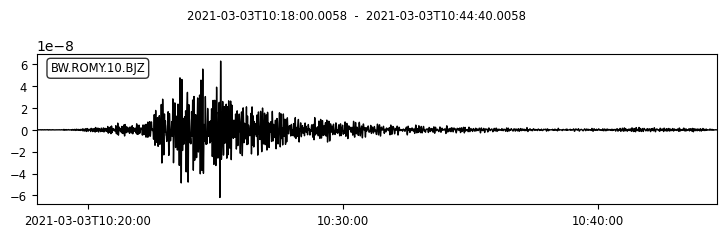

In [10]:
st, inv = __querrySeismoData(    
                            seed_id='BW.ROMY.10.BJZ',
                            starttime=tbeg,
                            endtime=tend,
                            where="george",
                            path=None,
                            restitute=True,
                            detail=None,
                             )



st.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=8, zerophase=True)

st.plot();

## Get Synthetic Signal

In [11]:
modeltrace = st[0].data

time_modeltrace = np.arange(modeltrace.size)/st[0].stats.sampling_rate

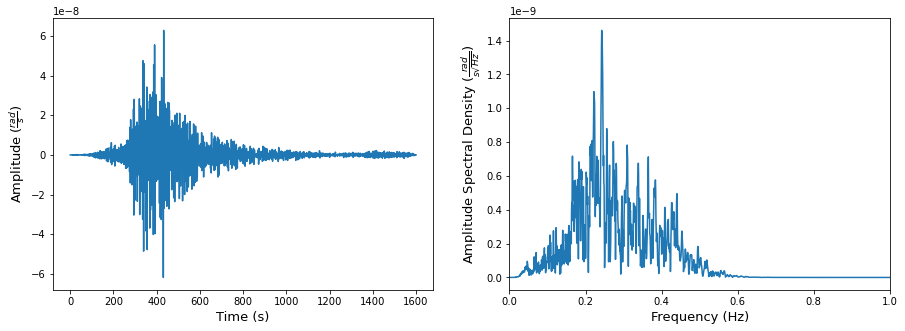

In [12]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=1); 

In [13]:

if oversampling:
    
#     modeltrace, time_modeltrace = __upsample_FIR(modeltrace, oversampling_factor, sps)

    modeltrace, time_modeltrace = __interpolation(modeltrace, time_modeltrace, T, oversampling_factor*sps)
    
    sps *= oversampling_factor

modeltrace.size, time_modeltrace.size

modeltrace is interpolated: 32001 samples --> 16000001 samples


(16000001, 16000001)

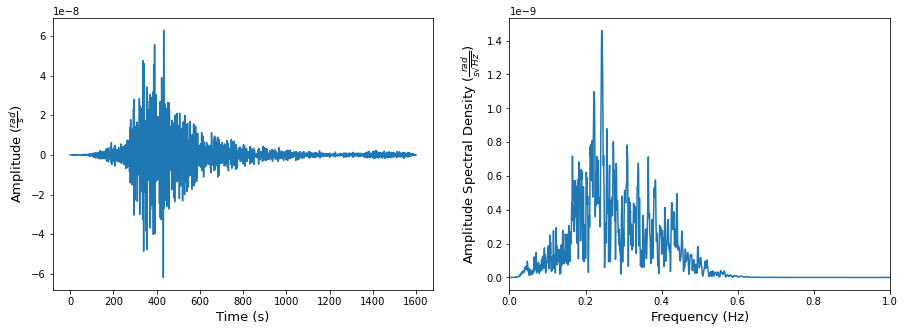

In [14]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=1); 

# Modulation

In [15]:

synthetic_signal, timeline = __modulation(modeltrace,
                                          time_modeltrace, 
                                          sgnc, 
                                          T, 
                                          sps, 
                                          modulation_index, 
                                          modulation_scheme,
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 6.37 sec


### Taper

In [16]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='window', percent=0.2)

### Plots

-553.7 1.37685744777


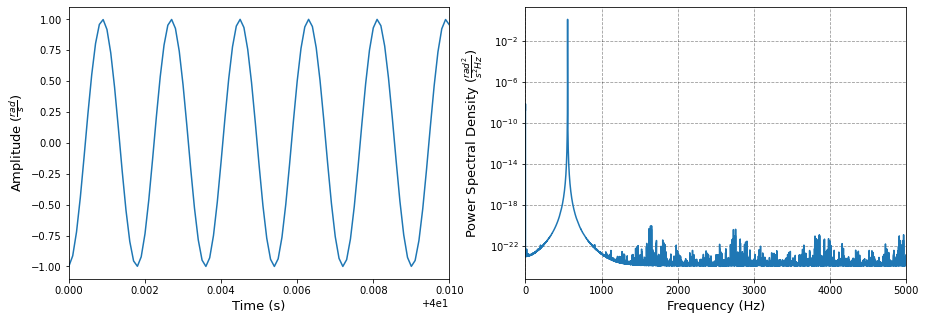

In [17]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);

-553.7 1.37685744777


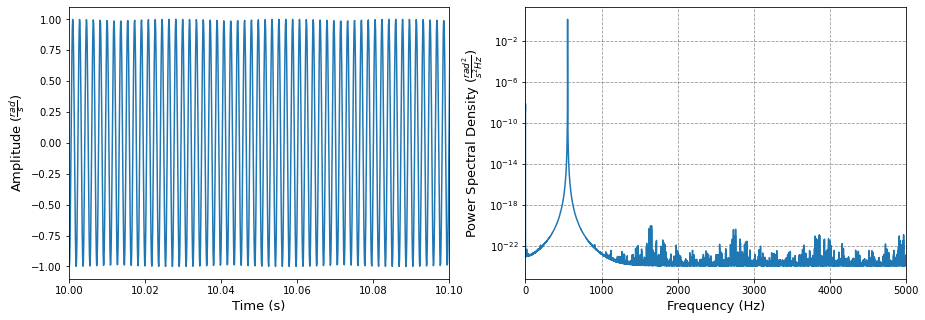

In [18]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=10, t2=10.1); 

## Downsample

The modulation has been performed with an oversampling factor to avoid erros. Now the result is resampled mimicing the real sampling of the analog signal.

In [19]:

def __downsample(signal_in, sps, ds_factor=oversampling_factor):
    
    
#     tmp = Trace(signal_in)
#     tmp.stats.delta = 1/sps
    
#     tmp.resample(int(sps/2)) # using FFT
    
#     tmp.filter('lowpass', freq=2400, corners=8, zerophase=True)
#     signal_out = tmp.data

    signal_out = decimate(signal_in, ds_factor, n=None, ftype='fir', axis=-1, zero_phase=True)
    
    sps = int(sps/ds_factor)
    
#     signal_out = signal_out[::ds_factor]
    time_out = np.arange(signal_out.size)/sps

    return signal_out, time_out, sps


In [20]:
synthetic_signal.size, modeltrace.size

(16000001, 16000001)

In [21]:
if oversampling:

    sps0 = sps ## prevent overwriting
    synthetic_signal, timeline, sps = __downsample(synthetic_signal, sps0, ds_factor=oversampling_factor)
    modeltrace, time_modeltrace, sps = __downsample(modeltrace, sps0, ds_factor=oversampling_factor)


synthetic_signal.size, modeltrace.size

(8000001, 8000001)

-553.65 2.57585304916


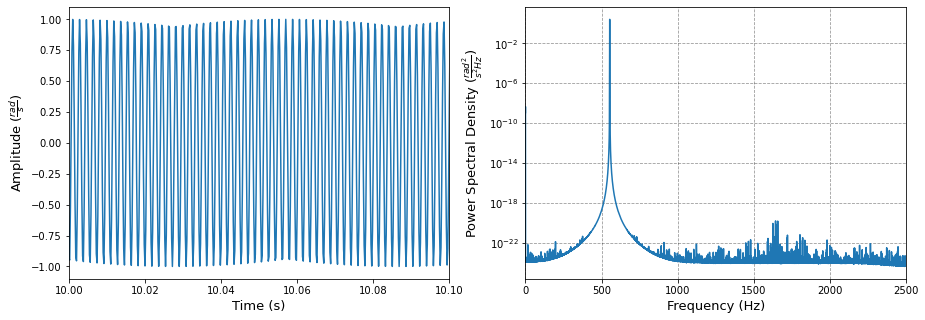

In [22]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=10, t2=10.1); 

## Write 

In [24]:
# oname = "greece2"  # "model_greece" , "model_lowperiod", "eigenmodes", "car"

# ofile = open(f"/home/andbro/notebooks/Sagnac_processing/data/{oname}.syn","wb")

# pickle.dump(synthetic_signal, ofile)

# ofile.close()


# ofile = open(f"/home/andbro/notebooks/Sagnac_processing/data/{oname}.mod","wb")

# pickle.dump(modeltrace, ofile)

# ofile.close()